# Load the Data and Initial Packages

In [1]:
import os, numpy as np, pandas as pd, csv, matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import RandomizedSearchCV as srch
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as CR
from sklearn.preprocessing import MinMaxScaler as MMS
from matplotlib import pyplot as plt

scaler = MMS()

#Kaggle Data Set
train=pd.read_csv('C:/Users/lfult/Documents/mnist/train.csv')
test=pd.read_csv('C:/Users/lfult/Documents/mnist/test.csv')
trainlab=train['label']
train=train.drop(columns=['label'])
train=train.values.reshape(42000,28,28)
train=train/255
test=test.values.reshape(28000,28,28)
test=test/255

print(train.shape,test.shape)

(42000, 28, 28) (28000, 28, 28)


# Look at Images

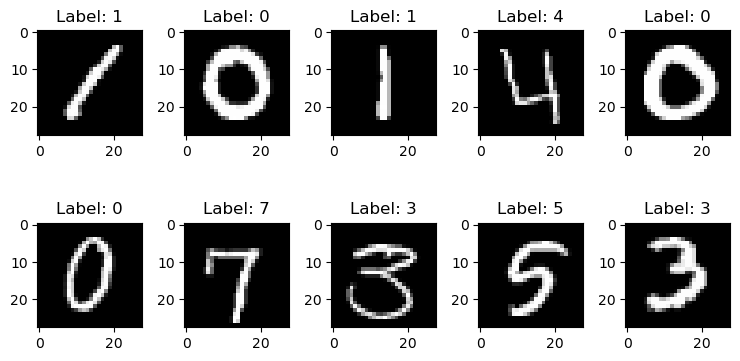

In [2]:
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainlab[i]))
plt.tight_layout()
plt.show()

# Frequency and Relative Frequency 

In [3]:
uniq,counts=np.unique(trainlab, return_counts=True)
tot=np.round(counts/sum(counts),2)
print(pd.DataFrame(np.asarray((uniq, counts,tot))).T)

     0       1     2
0  0.0  4132.0  0.10
1  1.0  4684.0  0.11
2  2.0  4177.0  0.10
3  3.0  4351.0  0.10
4  4.0  4072.0  0.10
5  5.0  3795.0  0.09
6  6.0  4137.0  0.10
7  7.0  4401.0  0.10
8  8.0  4063.0  0.10
9  9.0  4188.0  0.10


# Mean Pixel Intensity

The mean pixel intensity tells us how much ink is used on average to write the numbers. Less ink on average is used for the 1 (0.08 scaled). The most ink on average is used for the 8 (0.16). This gives us a clue on a potential classifier:  mean ink.

In [4]:
temp=np.reshape(train, (42000,28*28))
temp=pd.DataFrame(temp)
temp['label']=trainlab
temp.groupby('label').mean()

for i in range(10):
    temp2= temp[temp['label'] ==i] 
    temp2=np.asarray(temp2)
    print(i,np.mean(temp2))    

0 0.17301065343236088
1 0.0771498252436462
2 0.1517726956593135
3 0.14529880356067426
4 0.12615322840059146
5 0.135436095524453
6 0.14619666457549424
7 0.12347318227884393
8 0.16097988466343494
9 0.13412638940926694


# Set up Validation Set for RF and for Multinomial

In [5]:
X_train, X_valid, y_train, y_valid = tts(train,  trainlab,test_size=0.2, random_state=42)
X_train=X_train.reshape(33600,28*28)
X_valid=X_valid.reshape(8400,28*28)
train=train.reshape(42000,28*28)
test=test.reshape(28000,28*28)
print(X_train.shape,X_valid.shape, train.shape,test.shape)

(33600, 784) (8400, 784) (42000, 784) (28000, 784)


# Multinomial

In [6]:
from sklearn.naive_bayes import MultinomialNB as mn
clf = mn()
clf.fit(X_train,y_train)
print(clf.score(X_valid,y_valid))

0.8258333333333333


In [7]:
pd.crosstab(y_valid, clf.predict(X_valid), margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
0,742,0,3,2,1,15,16,0,37,0,816
1,0,858,9,3,0,1,2,0,33,3,909
2,9,15,698,24,10,2,33,5,50,0,846
3,2,17,44,751,1,26,10,10,50,26,937
4,3,0,4,0,613,3,24,3,31,158,839
5,18,6,5,72,23,468,23,3,61,23,702
6,12,10,8,1,5,21,717,0,11,0,785
7,5,19,10,2,17,0,1,740,25,74,893
8,3,35,6,50,14,31,11,1,651,33,835


# Clustering

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
kmeans=KMeans(n_clusters=300, random_state=1234).fit(X_train)
kmeans.labels_
print(kmeans.labels_)
myct=pd.crosstab(y_train, kmeans.labels_)
myct=pd.DataFrame(myct)
print(myct)

C:\Users\lfult\.conda\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[245  35 134 ...  62 245  86]
col_0  0    1    2    3    4    5    6    7    8    9    ...  290  291  292  \
label                                                    ...                  
0        5    0    0    0  109    0    0    0   91    0  ...    0    0    0   
1        0  228    0    0    0    0  182    2    0    0  ...    0  128    0   
2        0    3    1    0    0    0    0    1    0    1  ...    0    4   60   
3        1    0    3  111    0    0    0    0    0    0  ...    0    0    5   
4        0    1   11    0    0    0    1   17    0    0  ...    5    0    0   
5        1    0    2    0    0    0    0    0    1    0  ...    2    0    0   
6       46    0    0    0    0  110    1    0    0    0  ...    0    0    0   
7        0    7   37    0    0    0    5   12    0  123  ...    2    1    2   
8        4    1    1    0    0    0    0    1    1    0  ...    1    0    2   
9        0    2   23    1    0    0    3  134    0    2  ...   62    0    1   

col_0  293  294  295 

# Translate the Cluster Values to a Dictionary

In [9]:
tmp=myct.idxmax() #get the index value associated with the maximum in the column

mydict={}
for i in range(len(tmp)):
    mydict[i]=tmp[i]

   
pred=kmeans.predict(X_valid)
pred=pd.DataFrame(pred)
pred=pred.replace(dict(mydict))
pred=np.squeeze(np.asarray(pred))
myct=pd.crosstab(y_valid, pred)
print(sum(np.diagonal(myct))/len(pred))

0.9175


# Cross Tab

In [10]:
myct

col_0,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,796,0,0,2,4,2,10,0,2,0
1,0,899,2,3,0,0,4,0,0,1
2,4,10,785,5,2,2,3,18,13,4
3,3,3,12,835,2,31,1,12,29,9
4,1,4,9,0,734,0,7,2,0,82
5,0,1,6,40,2,615,14,5,16,3
6,10,0,2,0,4,3,764,0,2,0
7,0,17,12,0,9,0,0,793,4,58
8,3,7,6,19,4,32,4,4,749,7


# Random Forest

In [11]:
rf=rfc(random_state=1234, n_jobs=-1, 
       criterion='gini',n_estimators=300).fit(X_train, y_train)
print(rf.score(X_valid, y_valid))

0.9648809523809524


In [12]:
pd.crosstab(y_valid, rf.predict(X_valid), margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
0,805,0,1,0,2,1,4,0,3,0,816
1,0,902,4,0,1,1,1,0,0,0,909
2,3,4,811,5,10,0,4,3,6,0,846
3,2,1,6,884,1,13,0,10,11,9,937
4,1,0,1,0,815,0,6,2,0,14,839
5,1,0,2,9,0,670,8,2,5,5,702
6,3,1,1,0,1,2,773,0,4,0,785
7,0,3,10,1,7,0,0,853,2,17,893
8,1,3,3,9,6,4,4,2,798,5,835


# Time / Accuracy RF Fit on Complete Training Data

In [13]:
myrfc=rfc(n_estimators=300, criterion='gini', bootstrap=True)
start=datetime.now()
myfit=myrfc.fit(train, trainlab)
end=datetime.now()
myCR=CR(trainlab, myfit.predict(train))
print('time: ', end-start)

time:  0:01:02.708678


In [14]:
print(myCR)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4132
           1       1.00      1.00      1.00      4684
           2       1.00      1.00      1.00      4177
           3       1.00      1.00      1.00      4351
           4       1.00      1.00      1.00      4072
           5       1.00      1.00      1.00      3795
           6       1.00      1.00      1.00      4137
           7       1.00      1.00      1.00      4401
           8       1.00      1.00      1.00      4063
           9       1.00      1.00      1.00      4188

    accuracy                           1.00     42000
   macro avg       1.00      1.00      1.00     42000
weighted avg       1.00      1.00      1.00     42000



# Set Up Predictions

In [15]:
mypred,myseq=myfit.predict(test),np.arange(1,28001)
d = pd.DataFrame({'ImageId': myseq, 'Label': mypred}).to_csv("C:/Users/lfult/Documents/mnist/forsubmit1.csv", index=False)

# Result:  .96632

# Neural Net

In [16]:
#Tensorflow
import tensorflow as tf 
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential,Input,Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2 
import tensorflow.keras.backend as K #let's write our own metrics and loss functions

#Graphing
import cv2
import matplotlib.pyplot as plt

print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16374253030691406810
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14236516352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5225935026416811078
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Autoencoder

## Model

In [17]:
autoencoder=tf.keras.Sequential()
autoencoder.add(tf.keras.layers.Dense(784, activation='relu'))
autoencoder.add(tf.keras.layers.Dense(512, activation='relu'))
autoencoder.add(tf.keras.layers.Dense(256,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(128,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(64,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(32,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(16,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(10,  activation='linear',name='XGB'))
autoencoder.add(tf.keras.layers.Dense(16,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(32,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(64,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(128,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(256,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(512, activation='relu'))
autoencoder.add(tf.keras.layers.Dense(784, activation='sigmoid', name='CLEAN'))                               

## Compile and Run

In [18]:
batch=1024
numepochs=101 #run 

early = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("C:/Users/lfult/Documents/mnist/autoencode.hdf5", monitor='mean_squared_error', verbose=0,
    save_best_only=True, mode='auto')

with tf.device('/GPU:0'):  #Use the GPU
    autoencoder.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
    history = autoencoder.fit(train,train,validation_split=0.2,shuffle=True, epochs=numepochs, 
                       batch_size=batch,callbacks=[early,checkpoint], verbose=2)


Epoch 1/101
33/33 - 3s - loss: 0.1152 - mean_squared_error: 0.1152 - val_loss: 0.0723 - val_mean_squared_error: 0.0723 - 3s/epoch - 77ms/step
Epoch 2/101
33/33 - 0s - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - 271ms/epoch - 8ms/step
Epoch 3/101
33/33 - 0s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 282ms/epoch - 9ms/step
Epoch 4/101
33/33 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 277ms/epoch - 8ms/step
Epoch 5/101
33/33 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - 294ms/epoch - 9ms/step
Epoch 6/101
33/33 - 0s - loss: 0.0614 - mean_squared_error: 0.0614 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - 278ms/epoch - 8ms/step
Epoch 7/101
33/33 - 0s - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 0.0572 - val_mean_squared_error: 0.0572 - 281ms/epoch - 9ms

Epoch 58/101
33/33 - 0s - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - 250ms/epoch - 8ms/step
Epoch 59/101
33/33 - 0s - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 260ms/epoch - 8ms/step
Epoch 60/101
33/33 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - 185ms/epoch - 6ms/step
Epoch 61/101
33/33 - 0s - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - 268ms/epoch - 8ms/step
Epoch 62/101
33/33 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - 259ms/epoch - 8ms/step
Epoch 63/101
33/33 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - 269ms/epoch - 8ms/step
Epoch 64/101
33/33 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - 270ms/ep

## Encoded and Reconstructed Data

In [19]:
#Get the N x 10 data for passing to XGB
encoder=Model(autoencoder.input, autoencoder.get_layer('XGB').output)
#encoder.summary()  #This shows that we have captured the network from input to the XGB layer only.
#Encode Data..we might use this for classification rather than the original data
encoded_data = encoder.predict(train)  # For XGB (bottleeneck)
#Reconstructed Data
decoded_output = autoencoder.predict(train)        # reconstruction

1313/1313 [==============================] - 2s 1ms/step


In [20]:
#For decoder...We subtract out the initial layers to leave us with only the decoder
encoded_input = Input(shape=(10,))
decoder = autoencoder.layers[-7](encoded_input)
decoder = autoencoder.layers[-6](decoder)
decoder = autoencoder.layers[-5](decoder)
decoder = autoencoder.layers[-4](decoder)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)
#decoder.summary()  This shows that we have done it right.

In [21]:
print(decoded_output.shape, autoencoder.predict(train).shape)
print(train.shape)


1313/1313 [==============================] - 2s 1ms/step
(42000, 784) (42000, 784)
(42000, 784)


# Comparison of Original vs. Encoded Images

1313/1313 [==============================] - 2s 1ms/step


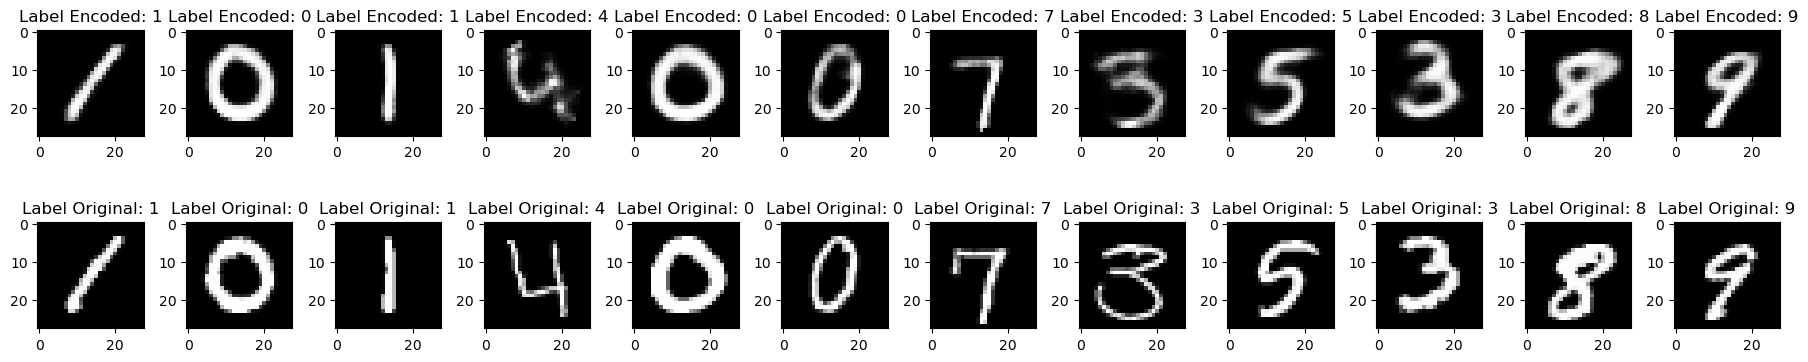

(42000, 784)


In [22]:
num_row = 2
num_col = 12 # plot images
#decoded=decoded_output.reshape(42000,28,28)
decoded=autoencoder.predict(train).reshape(42000,28,28)
newtrain=train.reshape(42000,28,28)
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_col):
    ax = axes[0, i%num_col]
    ax.imshow(decoded[i], cmap='gray')
    ax.set_title('Label Encoded: {}'.format(trainlab[i]))
for i in range(num_col):
    ax = axes[1, i%num_col]
    ax.imshow(newtrain[i], cmap='gray')
    ax.set_title('Label Original: {}'.format(trainlab[i]))
plt.tight_layout()
plt.show()
decoded=decoded.reshape(42000,28*28)
print(decoded.shape)

# Initial Neural Network

In [23]:
nnet=tf.keras.Sequential()
nnet.add(tf.keras.layers.Dense(784, activation='relu'))
nnet.add(tf.keras.layers.Dense(512,  activation='relu'))
nnet.add(tf.keras.layers.Dense(256,  activation='relu'))
nnet.add(tf.keras.layers.Dense(128,  activation='relu'))
nnet.add(tf.keras.layers.Dense(64,  activation='relu'))
nnet.add(tf.keras.layers.Dense(32,  activation='relu'))
nnet.add(tf.keras.layers.Dense(16,  activation='relu'))
nnet.add(tf.keras.layers.Dense(10,  activation='softmax', name='ForXGB'))

# Compile and Run

In [24]:
batch=512
numepochs=500
early = EarlyStopping(monitor='val_loss', mode='min', patience=100,restore_best_weights=True, verbose=2)
checkpoint = ModelCheckpoint("C:/Users/lfult/Documents/mnist/best_model.hdf5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto')
with tf.device('/GPU:0'):  #Use the GPU
    nnet.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = nnet.fit(train,trainlab,validation_split=.2,shuffle=True, epochs=numepochs, 
                       batch_size=batch,callbacks=[early,checkpoint])


Epoch 1/500
53/66 [=======================>......] - ETA: 0s - loss: 1.0880 - accuracy: 0.6252
Epoch 1: accuracy improved from -inf to 0.67827, saving model to C:/Users/lfult/Documents/mnist\best_model.hdf5
66/66 [==============================] - 1s 8ms/step - loss: 0.9530 - accuracy: 0.6783 - val_loss: 0.4117 - val_accuracy: 0.8863
Epoch 2/500
63/66 [===========================>..] - ETA: 0s - loss: 0.2257 - accuracy: 0.9395
Epoch 2: accuracy improved from 0.67827 to 0.94003, saving model to C:/Users/lfult/Documents/mnist\best_model.hdf5
66/66 [==============================] - 0s 5ms/step - loss: 0.2240 - accuracy: 0.9400 - val_loss: 0.1699 - val_accuracy: 0.9542
Epoch 3/500
60/66 [==========================>...] - ETA: 0s - loss: 0.1321 - accuracy: 0.9619
Epoch 3: accuracy improved from 0.94003 to 0.96211, saving model to C:/Users/lfult/Documents/mnist\best_model.hdf5
66/66 [==============================] - 0s 4ms/step - loss: 0.1310 - accuracy: 0.9621 - val_loss: 0.1452 - val_acc

Epoch 28/500
56/66 [========================>.....] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980
Epoch 28: accuracy did not improve from 0.99818
66/66 [==============================] - 0s 4ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.1236 - val_accuracy: 0.9774
Epoch 29/500
55/66 [========================>.....] - ETA: 0s - loss: 0.0073 - accuracy: 0.9977
Epoch 29: accuracy did not improve from 0.99818
66/66 [==============================] - 0s 4ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.1284 - val_accuracy: 0.9744
Epoch 30/500
58/66 [=========================>....] - ETA: 0s - loss: 0.0068 - accuracy: 0.9983
Epoch 30: accuracy improved from 0.99818 to 0.99845, saving model to C:/Users/lfult/Documents/mnist\best_model.hdf5
66/66 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.1224 - val_accuracy: 0.9796
Epoch 31/500
53/66 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 0.9989
Epoch 31: accurac

Epoch 56/500
56/66 [========================>.....] - ETA: 0s - loss: 5.7552e-06 - accuracy: 1.0000
Epoch 56: accuracy did not improve from 1.00000
66/66 [==============================] - 0s 3ms/step - loss: 5.8488e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9806
Epoch 57/500
60/66 [==========================>...] - ETA: 0s - loss: 5.4849e-06 - accuracy: 1.0000
Epoch 57: accuracy did not improve from 1.00000
66/66 [==============================] - 0s 3ms/step - loss: 5.4061e-06 - accuracy: 1.0000 - val_loss: 0.1507 - val_accuracy: 0.9806
Epoch 58/500
60/66 [==========================>...] - ETA: 0s - loss: 5.1125e-06 - accuracy: 1.0000
Epoch 58: accuracy did not improve from 1.00000
66/66 [==============================] - 0s 3ms/step - loss: 5.0053e-06 - accuracy: 1.0000 - val_loss: 0.1515 - val_accuracy: 0.9807
Epoch 59/500
58/66 [=========================>....] - ETA: 0s - loss: 4.7299e-06 - accuracy: 1.0000
Epoch 59: accuracy did not improve from 1.00000
66/66 [==

In [25]:
pred1=tf.argmax(nnet.predict(train),1)
pd.crosstab(trainlab, pred1, margins=True)

1313/1313 [==============================] - 1s 1ms/step


col_0,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
0,4111,0,2,1,0,2,8,0,6,2,4132
1,0,4656,1,2,7,0,0,10,8,0,4684
2,3,6,4128,8,6,1,6,8,8,3,4177
3,1,2,7,4278,2,25,0,5,22,9,4351
4,0,1,2,0,4057,0,2,3,1,6,4072
5,2,0,1,4,4,3766,2,0,10,6,3795
6,4,3,1,0,8,14,4106,0,1,0,4137
7,0,5,2,1,1,1,0,4388,1,2,4401
8,2,16,4,4,4,4,2,7,4015,5,4063


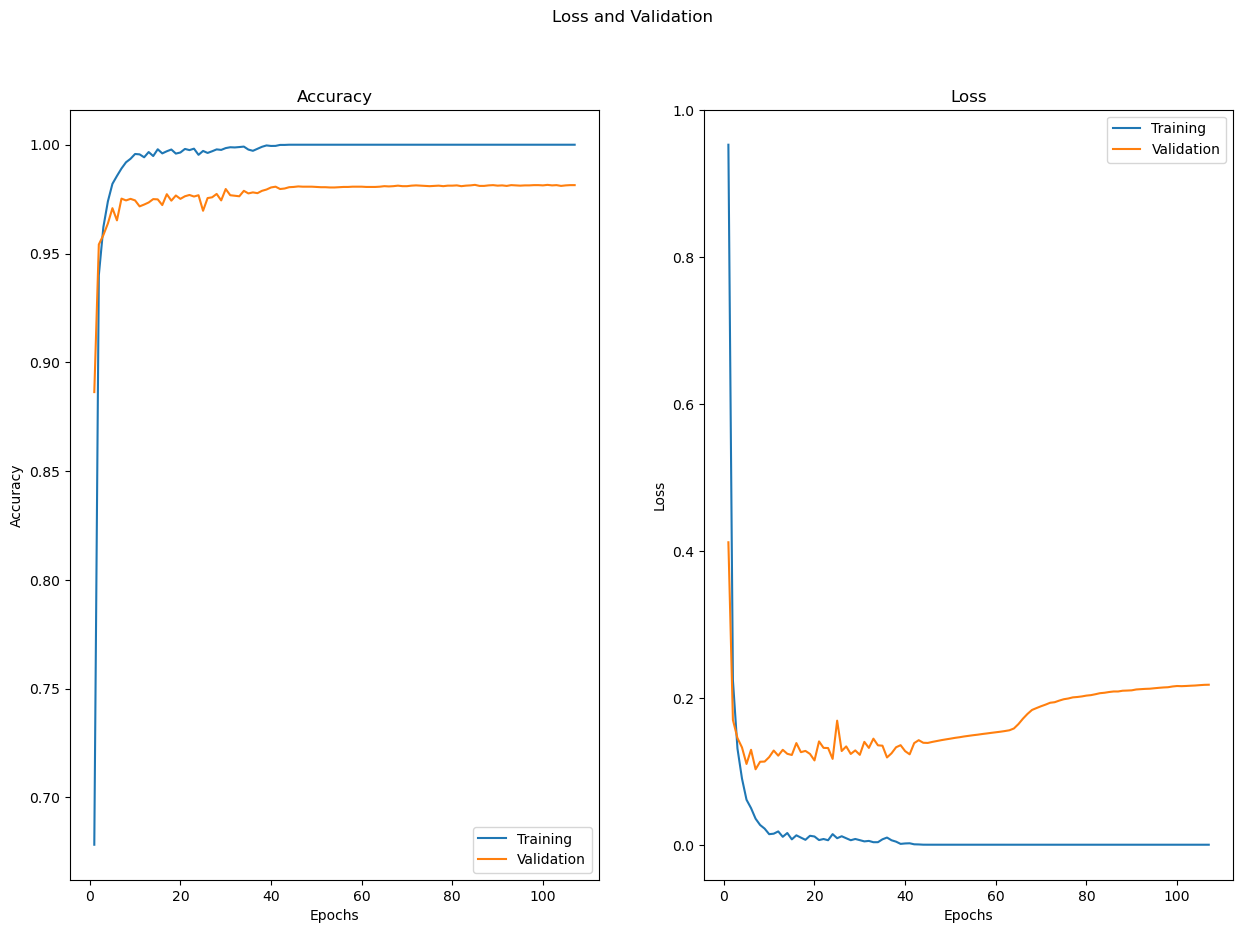

In [26]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Loss and Validation")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss'])

## Predictions from Neural Network

In [27]:
predictions,myseq=nnet.predict(test),np.arange(1,28001)
pd.DataFrame({'ImageId': myseq, 'Label': mypred}).to_csv("C:/Users/lfult/Documents/mnist/forsubmit2.csv", index=False)

875/875 [==============================] - 1s 1ms/step


# Neural Network + XGB

In [29]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

forxgboost=Model(nnet.input, nnet.get_layer('ForXGB').output)
encoded_data = forxgboost.predict(train)
encoded_data.shape

1313/1313 [==============================] - 1s 1ms/step


(42000, 10)

In [30]:
xgbc = xgb.XGBClassifier(use_label_encoder=False, verbosity=0, max_depth=6, learning_rate=.3, n_estimators=300)
myxgbfit=xgbc.fit(encoder.predict(train),trainlab)

C:\Users\lfult\.conda\envs\tf\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1313/1313 [==============================] - 1s 991us/step


In [31]:
myxgbfit.score(encoded_data, trainlab)

0.09673809523809523

In [32]:
pred2=tf.argmax(encoded_data,1)
pd.crosstab(trainlab, pred2, margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
0,4111,0,2,1,0,2,8,0,6,2,4132
1,0,4656,1,2,7,0,0,10,8,0,4684
2,3,6,4128,8,6,1,6,8,8,3,4177
3,1,2,7,4278,2,25,0,5,22,9,4351
4,0,1,2,0,4057,0,2,3,1,6,4072
5,2,0,1,4,4,3766,2,0,10,6,3795
6,4,3,1,0,8,14,4106,0,1,0,4137
7,0,5,2,1,1,1,0,4388,1,2,4401
8,2,16,4,4,4,4,2,7,4015,5,4063


In [33]:
sum(np.diagonal(pd.crosstab(trainlab,pred2)))/42000

0.9908095238095238

## Predictions from XGBoost after NN

In [34]:
testencode=encoder.predict(test)
pred3,myseq=myxgbfit.predict(testencode),np.arange(1,28001)
pd.DataFrame({'ImageId': myseq, 'Label': pred3}).to_csv("C:/Users/lfult/Documents/mnist/forsubmit3.csv", index=False)

875/875 [==============================] - 1s 977us/step
